In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import numpy as np
#from keras.metrics.probabilistic_metrics import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os
import PIL
import time
from IPython import display

In [7]:
root_path = "/kaggle/input/animefacedataset/images"
root_path = pathlib.Path(data_path)

In [8]:
# prepraing data
batch_size = 32

data = keras.utils.image_dataset_from_directory(
    directory=root_path,
    label_mode=None,
    batch_size=batch_size,
    image_size=(64,64))

Found 63565 files belonging to 1 classes.


In [9]:
data

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

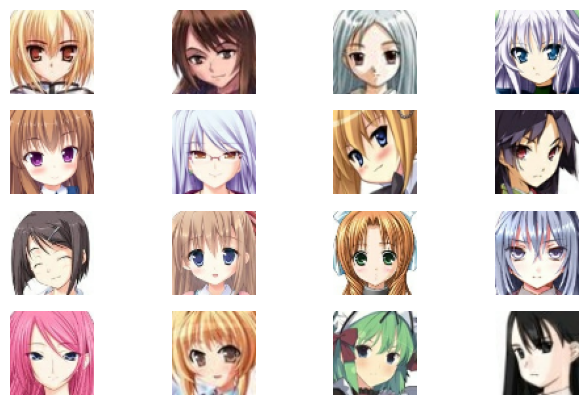

In [10]:
# let's see some images of the dataset
plt.figure(figsize=(8,5))
for images in data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
# normalizing the input image to the range [-1, 1]
data = data.map(lambda d : ((d-127.5)/127.5))
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [12]:
# Discriminator
def Discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU", input_shape=(64,64,3)))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=128, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=256, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(units=1, activation="sigmoid"))

  return discriminator

D_model = Discriminator()
D_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0

In [13]:
# optimizer
D_optm = Adam(1e-4)

In [14]:
latent_dim = 100

In [15]:
# Build the Generator function
def Generator():
  generator = Sequential()
  generator.add(Dense(units=4*4*256, input_shape =[latent_dim], use_bias=False))
  generator.add(Reshape((4,4,256)))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="tanh"))

  return generator


# a summary of the Generetor
G_model = Generator()
G_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              409600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 256)         1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         295040    
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 128)         512       
 chNormalization)                                                
                                                      

In [16]:
# optimizer
G_optm = Adam(1e-4)

In [17]:
# creating random noise
random_noise = tf.random.normal([1,latent_dim])

In [18]:
# feeding random noise to Genereator
G_output_on_random_noise = G_model(random_noise, training=False)

(-0.5, 63.5, 63.5, -0.5)

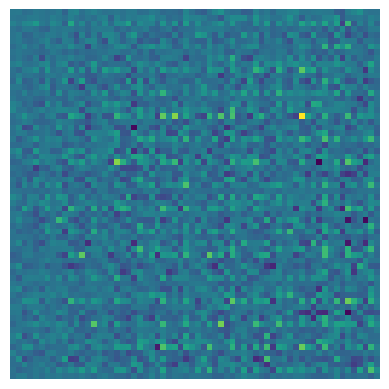

In [19]:
# showing the image output of G_model
plt.imshow(G_output_on_random_noise[0, :, :, 0])
plt.axis("off")

In [20]:
# feeding the output of Generator to Discriminator
D_output_on_random_noise = D_model(G_output_on_random_noise)
print(D_output_on_random_noise)

tf.Tensor([[0.50000346]], shape=(1, 1), dtype=float32)


In [21]:
# The code of this cell is from keras sample.
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [22]:
# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [23]:
# Defining GAN model
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

In [24]:
# Compiling GAN Model
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

In [25]:
# number of epochs
epochs = 35
# Fitting the GAN model
history = model.fit(data, epochs=epochs)

Epoch 1/35
1987/1987 [==============================] - 83s 38ms/step - d_loss: 0.6178 - g_loss: 154.3492
Epoch 2/35
1987/1987 [==============================] - 52s 26ms/step - d_loss: 0.2251 - g_loss: 5.6428
Epoch 3/35
1987/1987 [==============================] - 53s 26ms/step - d_loss: 0.1739 - g_loss: 4.1445
Epoch 4/35
1987/1987 [==============================] - 53s 27ms/step - d_loss: 0.2270 - g_loss: 3.4383
Epoch 5/35
1987/1987 [==============================] - 53s 27ms/step - d_loss: 0.2157 - g_loss: 3.5977
Epoch 6/35
1987/1987 [==============================] - 53s 27ms/step - d_loss: 0.2844 - g_loss: 3.0297
Epoch 7/35
1987/1987 [==============================] - 54s 27ms/step - d_loss: 0.2825 - g_loss: 2.8108
Epoch 8/35
1987/1987 [==============================] - 54s 27ms/step - d_loss: 0.2774 - g_loss: 2.8475
Epoch 9/35
1987/1987 [==============================] - 54s 27ms/step - d_loss: 0.2811 - g_loss: 2.8550
Epoch 10/35
1987/1987 [==============================] - 54s 2

In [26]:
# creating a random nosie to feed it to the trained Generator model
noise = tf.random.normal([32, 100])
# Generatine new images using the trained Generator model 
generated_images = G_model(noise, training=False)

In [27]:
# converting the input image to the range [0, 255]
generated_images1 = (generated_images+127.5)*127.5

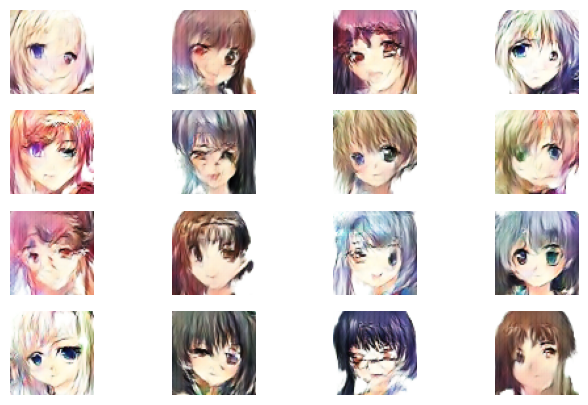

In [28]:
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()